# Importing libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import randint
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

In [3]:
df_train = pd.read_csv("Training_DataSet.csv")
df_test = pd.read_csv("Test_Dataset.csv")
tempdf = df_train.copy()
#tempdf = df_test.copy()
#Need to assign tempdf to either test or training

## EDA

In [4]:
df_train.dtypes

ListingID                 int64
SellerCity               object
SellerIsPriv               bool
SellerListSrc            object
SellerName               object
SellerRating            float64
SellerRevCnt              int64
SellerState              object
SellerZip               float64
VehBodystyle             object
VehCertified               bool
VehColorExt              object
VehColorInt              object
VehDriveTrain            object
VehEngine                object
VehFeats                 object
VehFuel                  object
VehHistory               object
VehListdays             float64
VehMake                  object
VehMileage              float64
VehModel                 object
VehPriceLabel            object
VehSellerNotes           object
VehType                  object
VehTransmission          object
VehYear                   int64
Vehicle_Trim             object
Dealer_Listing_Price    float64
dtype: object

In [5]:
df_train.isna().sum()

ListingID                 0
SellerCity                0
SellerIsPriv              0
SellerListSrc             2
SellerName                0
SellerRating              0
SellerRevCnt              0
SellerState               0
SellerZip                 2
VehBodystyle              0
VehCertified              0
VehColorExt              73
VehColorInt             728
VehDriveTrain           401
VehEngine               361
VehFeats                275
VehFuel                   2
VehHistory              201
VehListdays               2
VehMake                   0
VehMileage                2
VehModel                  0
VehPriceLabel           285
VehSellerNotes          243
VehType                   0
VehTransmission         197
VehYear                   0
Vehicle_Trim            405
Dealer_Listing_Price     52
dtype: int64

In [6]:
df_train.describe()

,ListingID,SellerRating,SellerRevCnt,SellerZip,VehListdays,VehMileage,VehYear,Dealer_Listing_Price
count,6.298000e+03,6298.000000,6298.000000,6296.000000,6296.000000,6296.000000,6298.000000,6246.000000
mean,4.318130e+06,4.138346,434.565576,45234.211722,56.143670,26369.364358,2016.792633,32265.053314
std,2.486031e+06,1.188033,1274.257411,20380.478191,68.301329,13036.568712,1.206566,7538.339005
min,3.287000e+03,0.000000,0.000000,1105.000000,0.293102,0.000000,2015.000000,18289.000000
25%,2.178112e+06,4.000000,28.000000,28806.000000,12.998391,16835.000000,2015.000000,26900.000000
50%,4.298122e+06,4.600000,126.000000,46410.000000,33.463484,26181.000000,2017.000000,31455.500000
75%,6.488249e+06,4.800000,401.000000,60126.000000,74.139769,36468.500000,2018.000000,35991.000000
max,8.620012e+06,5.000000,14635.000000,99654.000000,820.684375,83037.000000,2019.000000,89500.000000


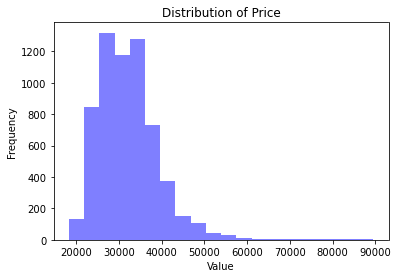

In [7]:
#Price distribution

# Create a histogram of the data
if 'Dealer_Listing_Price' in tempdf.columns:
    fig, ax = plt.subplots()
    ax.hist(tempdf["Dealer_Listing_Price"], bins=20, color='blue', alpha=0.5)

    # Set the title and labels for the axis
    ax.set_title('Distribution of Price')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    #Needs a transformation for normal distribution

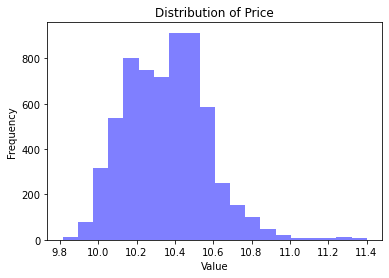

In [8]:
if 'Dealer_Listing_Price' in tempdf.columns:
    #Log transformation on price distribution
    fig, ax = plt.subplots()

    # Create a histogram of the data
    ax.hist(np.log(tempdf["Dealer_Listing_Price"]), bins=20, color='blue', alpha=0.5)

    # Set the title and labels for the axis
    ax.set_title('Distribution of Price')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

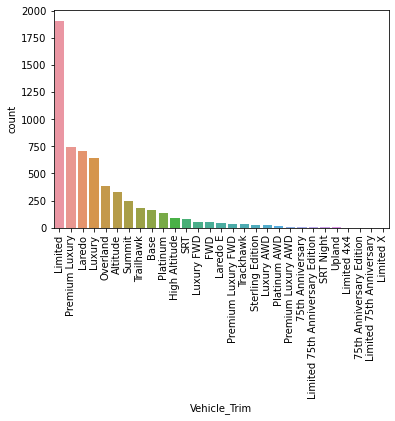

In [9]:
if 'Vehicle_Trim' in tempdf.columns:
    ax = sns.countplot(x = 'Vehicle_Trim', order=df_train['Vehicle_Trim'].value_counts().index, data=df_train)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

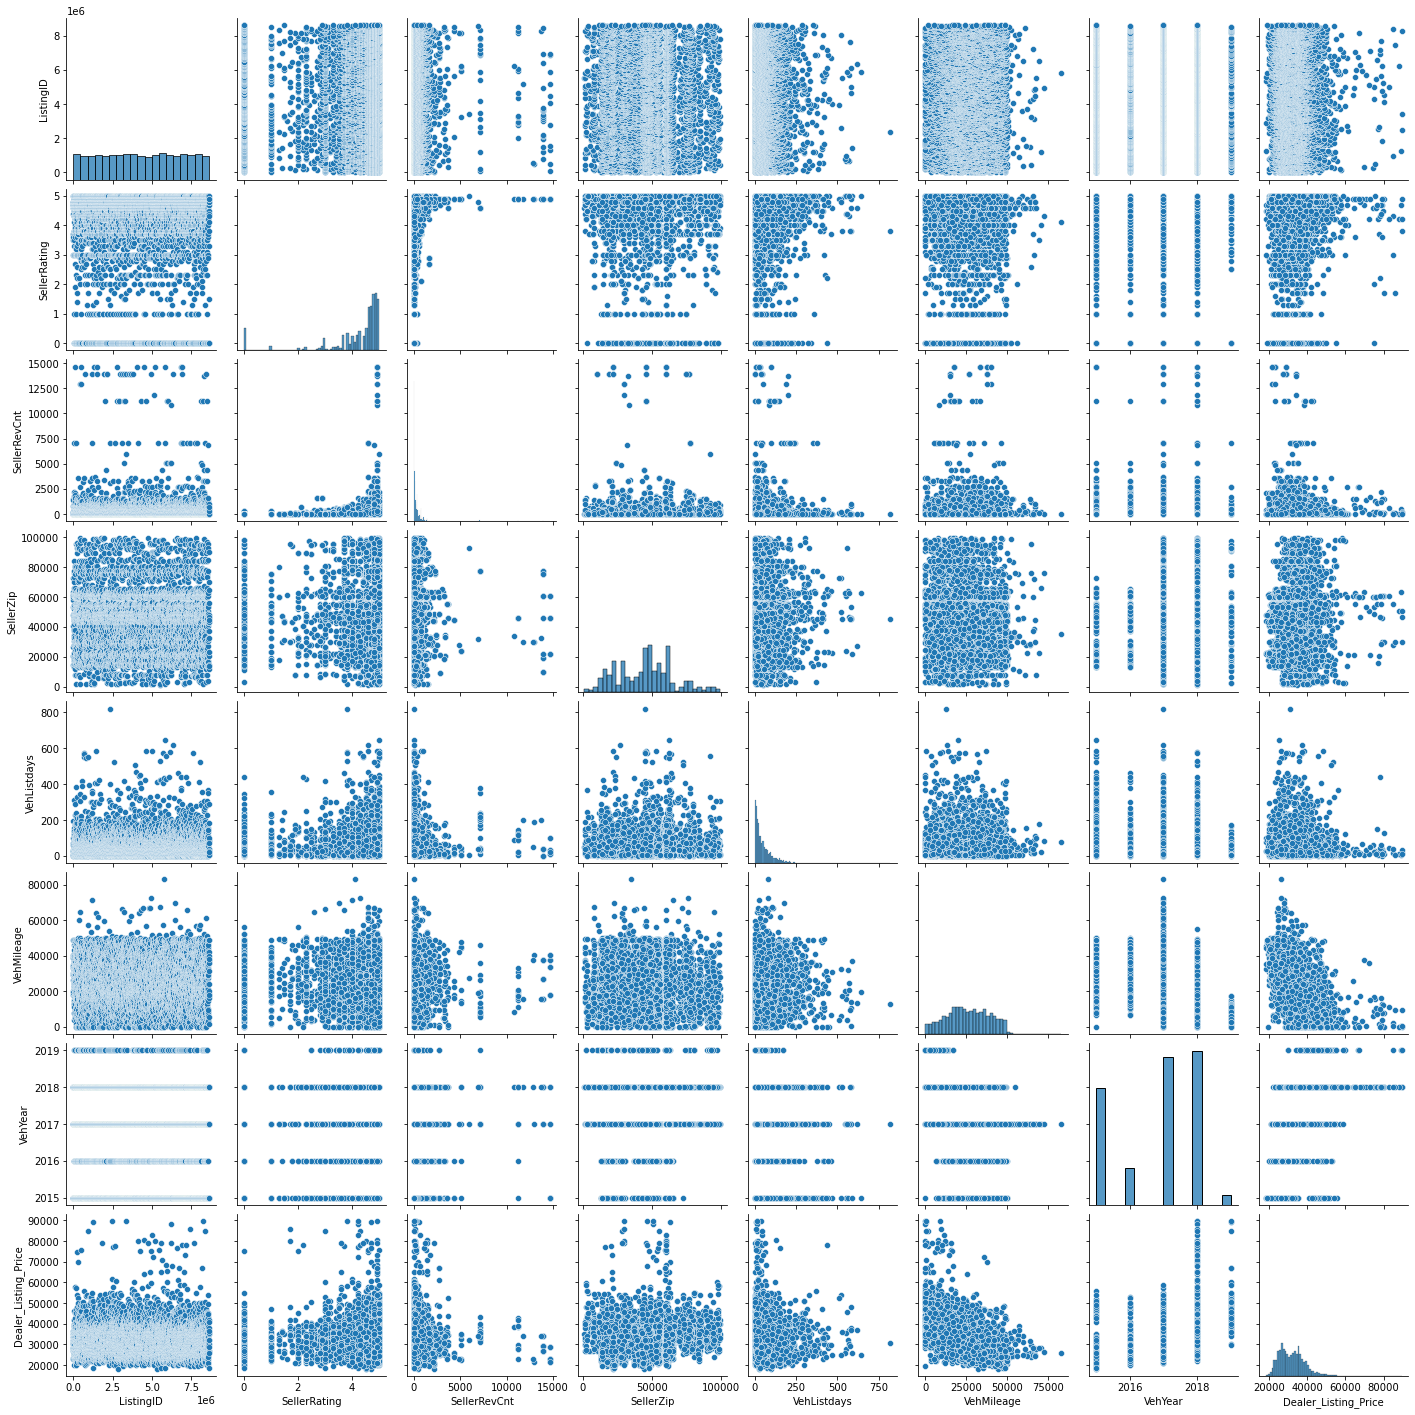

In [10]:
num_df = df_train.select_dtypes(include=['float64', 'int64'])
sns.pairplot(num_df)
#remove listinID
#create interaction between rating and review
#zipcode should be categorical
#transform VehListDays and VehMileage
#VehYear needs to be normalized

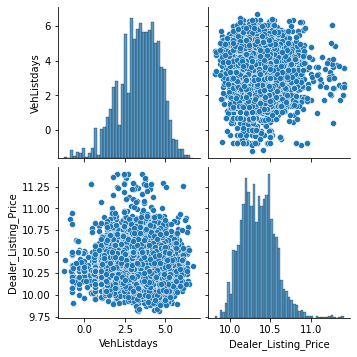

In [11]:
#Better "linear" relationship between the two with log transformation
x = df_train.copy()
x['VehListdays'] = np.log(x['VehListdays'])
x['Dealer_Listing_Price'] = np.log(x['Dealer_Listing_Price'])
sns.pairplot(x[['VehListdays', 'Dealer_Listing_Price']])

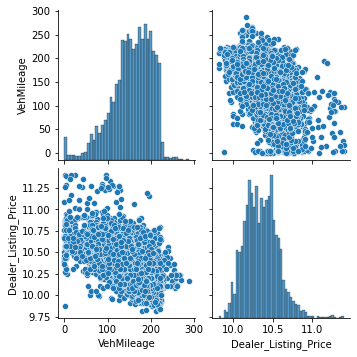

In [12]:
#Taking square root, results in a better transformation
x = df_train.copy()
x['VehMileage'] = np.sqrt(x['VehMileage'])
x['Dealer_Listing_Price'] = np.log(x['Dealer_Listing_Price'])
sns.pairplot(x[['VehMileage', 'Dealer_Listing_Price']])

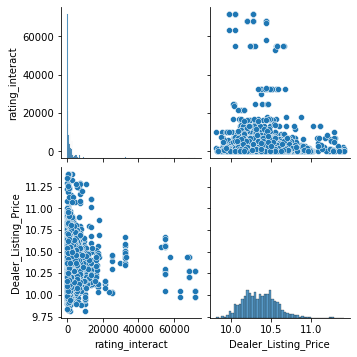

In [13]:
#log the interactive variable for a "better" relationship
x = df_train.copy()
x['rating_interact'] = x['SellerRating']*x['SellerRevCnt'] + 0.01
x['Dealer_Listing_Price'] = np.log(x['Dealer_Listing_Price'])
sns.pairplot(x[['rating_interact', 'Dealer_Listing_Price']])

## Data Cleaning

In [14]:
#Dropping columns that we will not be using
cols_to_drop = ['ListingID', 'SellerCity', 'SellerName', 'SellerState', 'VehBodystyle', 'VehType']
tempdf = tempdf.drop(cols_to_drop, axis = 1)

In [15]:
#SellerIsPriv: One hot encoding
tempdf = pd.get_dummies(tempdf, prefix=['isPriv'], columns = ['SellerIsPriv'],
                            drop_first=False)

In [16]:
#SellerListSrc: One hot encoding
tempdf = pd.get_dummies(tempdf, prefix=['list_src'], columns = ['SellerListSrc'],
                            drop_first=False)

In [17]:
#SellerRating: 
tempdf['rating_interact'] = tempdf['SellerRating']*tempdf['SellerRevCnt']
cols_to_drop = ["SellerRating", "SellerRevCnt"]
tempdf = tempdf.drop(cols_to_drop, axis = 1)

In [18]:
#SellerZip:
x = tempdf.copy()
x['SellerZip'] = str(x['SellerZip'])
for i in range(len(tempdf)):
    x['SellerZip'][i] = str(tempdf['SellerZip'][i])
tempdf['SellerZip'] = x['SellerZip'].str[0]

/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
tempdf = pd.get_dummies(tempdf, prefix = ['zip'], columns = ['SellerZip'],
                       drop_first = False)
if 'zip_n' in tempdf.columns:
    tempdf = tempdf.drop('zip_n', axis = 1)

In [20]:
tempdf = pd.get_dummies(tempdf, prefix = ['veh_certified'], columns = ['VehCertified'], drop_first = False)

In [21]:
#Cleaning and creating dummy variables for VehColorExt and #VehColorInt
ext_colors = ["red","blue","green","yellow","purple","orange","pink", "brown", "black", "white", "gray", "grey", "gold",
         "silver","teal","violet", "maroon", "beige", "unspecified", "charcoal", "clear-coat", "clear coat",
         "clearcoat", "pearl-coat", "pearl coat", "pearlcoat", "metallic", "not specified"]
#may need to add pearlcoats and other variables if needed
for i in ext_colors:
    tempdf[i] = 0
#make everything lower case for colors
tempdf['VehColorExt'] = tempdf['VehColorExt'].str.lower()
tempdf['VehColorInt'] = tempdf['VehColorInt'].str.lower()
for i in tempdf.columns[len(tempdf.columns) - len(ext_colors):len(tempdf.columns)]:
    for j in range(len(tempdf)):
        if str(i) in str(tempdf['VehColorExt'][j]):
            tempdf[i][j] = 1
    tempdf.rename(columns = {i:i+"_ext"}, inplace = True)

tempdf['unspecified_veh_ext'] = tempdf["unspecified_ext"] + tempdf["not specified_ext"]
tempdf['clear_coat_ext']  = tempdf['clearcoat_ext'] + tempdf['clear-coat_ext'] + tempdf['clear coat_ext']
tempdf['pearl_coat_ext'] = tempdf['pearl-coat_ext'] + tempdf["pearl coat_ext"] + tempdf['pearlcoat_ext']
tempdf['grey_veh_ext'] = tempdf['grey_ext'] + tempdf['gray_ext']
tempdf = tempdf.drop(columns = ['unspecified_ext', "not specified_ext", 'clearcoat_ext', 'clear-coat_ext',
                               'clear coat_ext', 'pearl-coat_ext', 'pearl coat_ext', 'pearlcoat_ext',
                               'grey_ext', 'gray_ext'])

int_colors = ["red","blue","green","yellow","purple","orange","pink", "brown", "black", "white", "gray", "grey", "gold",
         "silver","teal","violet", "maroon", "beige", "unspecified", "leather", "not specified"]
for i in int_colors:
    tempdf[i] = 0
for i in tempdf.columns[len(tempdf.columns)-len(int_colors):len(tempdf.columns)]:
    for j in range(len(tempdf)):
        if str(i) in str(tempdf['VehColorInt'][j]):
            tempdf[i][j] = 1
    tempdf.rename(columns = {str(i):str(i)+"_int"}, inplace = True)

tempdf['unspecified_veh_int'] = tempdf["unspecified_int"] + tempdf["not specified_int"]
tempdf['grey_veh_int'] = tempdf['grey_int'] + tempdf['gray_int']
tempdf = tempdf.drop(columns = ['unspecified_int', 'not specified_int', 'grey_int', 'gray_int'])


/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
#Adding na as variables and merging
tempdf['veh_ext_isna'] = tempdf['VehColorExt'].isna().astype(int)
tempdf['veh_int_isna'] = tempdf['VehColorInt'].isna().astype(int)

In [23]:
#Dropping columns with 0 sums for color
new_df = tempdf.loc[:,'red_ext':'veh_int_isna']
cols_to_drop = new_df.columns[new_df.sum() == 0]
tempdf = tempdf.drop(cols_to_drop, axis = 1)
tempdf = tempdf.drop(['VehColorExt', 'VehColorInt'], axis = 1)

In [24]:
#tempdf['VehDriveTrain'].value_counts()
#tempdf['VehDriveTrain'].unique()
four_wheel_drive = ["4X4", "4x4/4WD", '4WD', '4x4', 'FourWheelDrive', 'AWDor4x4','4x4/4-wheeldrive','4WD/AWD']
front_wheel_drive = ['FWD', 'FRONT-WHEELDRIVE','FrontWheelDrive','Front-wheelDrive', '2WD']
all_wheel_drive = ['AWD','AllWheelDrive','ALL-WHEELDRIVEWITHLOCKINGANDLIMITED-SLIPDIFFERENTIAL',
       'AWDor4x4', 'ALL-WHEELDRIVE', 'All-wheelDrive','ALLWHEEL', 'AllWheelDrive', '4WD/AWD']

tempdf['VehDriveTrain'] = tempdf['VehDriveTrain'].str.replace('\s+', '', regex=True)

four_wheel_func = lambda x: 1 if any(item in four_wheel_drive for item in str(x).split()) else 0
front_wheel_func = lambda x: 1 if any(item in front_wheel_drive for item in str(x).split()) else 0
all_wheel_func = lambda x: 1 if any(item in all_wheel_drive for item in str(x).split()) else 0
na_func = lambda x: 1 if(pd.isna(x)) else 0

tempdf['four_wheel_drive'] = tempdf['VehDriveTrain'].apply(four_wheel_func)
tempdf['front_wheel_drive'] = tempdf['VehDriveTrain'].apply(front_wheel_func)
tempdf['all_wheel_drive'] = tempdf['VehDriveTrain'].apply(all_wheel_func)
tempdf['na_wheel_drive'] = tempdf['VehDriveTrain'].apply(na_func)

tempdf = tempdf.drop(['VehDriveTrain'], axis = 1)

In [25]:
#tempdf['VehEngine'].unique()
#displacement column: extract numbers before and after, store it in a list and check again w for loop
#tempdf['VehEngine'].value_counts()
tempdf['VehEngine'] = tempdf['VehEngine'].fillna('')
engine_unique_val = {}
for row in tempdf['VehEngine']:
    values = row.split()
    for value in values:
        if value not in engine_unique_val:
            engine_unique_val[value] = 0
        engine_unique_val[value] += 1
#for value,count in engine_unique_val.items():
 #   print(value, count)


three_six_L = ['3.6L', '3.6', '3.6L/222.6', '3.6L/222']
V_six = ['V6', 'V-6', 'V6,']
regular = ['regular','unleaded']
twenty_four_V = ['24V']
mpfi = ['MPFI']
dohc = ['DOHC']
gdi = ['GDI']
vvt = ['VVT', 'VVT,']
five_seven_L = ['5.7L', '5.7']
V_eight = ['V8', 'V-8']



three_six_L_func = lambda x: 1 if any(item in three_six_L for item in str(x).split()) else 0
V_six_func = lambda x: 1 if any(item in V_six for item in str(x).split()) else 0
regular_func = lambda x: 1 if any(item in regular for item in str(x).split()) else 0
twenty_four_V_func = lambda x: 1 if any(item in twenty_four_V for item in str(x).split()) else 0
mpfi_func = lambda x: 1 if any(item in mpfi for item in str(x).split()) else 0
dohc_func = lambda x: 1 if any(item in dohc for item in str(x).split()) else 0
gdi_func = lambda x: 1 if any(item in gdi for item in str(x).split()) else 0
vvt_func = lambda x: 1 if any(item in vvt for item in str(x).split()) else 0
five_seven_L_func = lambda x: 1 if any(item in five_seven_L for item in str(x).split()) else 0
V_eight_func = lambda x: 1 if any(item in V_eight for item in str(x).split()) else 0


tempdf['three_six_L'] = tempdf['VehEngine'].apply(three_six_L_func)
tempdf['V_six'] = tempdf['VehEngine'].apply(V_six_func)
tempdf['regular'] = tempdf['VehEngine'].apply(regular_func)
tempdf['twenty_four_v'] = tempdf['VehEngine'].apply(twenty_four_V_func)
tempdf['mpfi'] = tempdf['VehEngine'].apply(mpfi_func)
tempdf['dohc'] = tempdf['VehEngine'].apply(dohc_func)
tempdf['gdi'] = tempdf['VehEngine'].apply(gdi_func)
tempdf['vvt'] = tempdf['VehEngine'].apply(vvt_func)
tempdf['five_seven_L'] = tempdf['VehEngine'].apply(five_seven_L_func)
tempdf['V_eight'] = tempdf['VehEngine'].apply(V_eight_func)


tempdf = tempdf.drop(['VehEngine'], axis = 1)

In [26]:
#tempdf['VehFeats'].unique()
#extract by splitting based on comma and removing special characters.
    #store each value in a list as a key and check with the for loop against the list to ensure the value is there
    #and add one on value if its in the list.

tempdf['VehFeats'] = tempdf['VehFeats'].fillna('no_feats')
tempdf['VehFeats'] = tempdf['VehFeats'].str.lower()
tempdf['VehFeats'] = tempdf['VehFeats'].apply(lambda x: re.sub(r'[^\w\s,]+', '', x))
tempdf['VehFeats'] = tempdf['VehFeats'].str.replace(", ", ',')


engine_unique_val = {}
for row in tempdf['VehFeats']:
    values = row.split(",")
    for value in values:
        if value not in engine_unique_val:
            engine_unique_val[value] = 0
        engine_unique_val[value] += 1
sorted_items = sorted(engine_unique_val.items(), key=lambda x: x[1], reverse=True)

for item, val in sorted_items[0:20]:
    func = lambda x: 1 if any(feats in item for feats in x.split(",")) else 0
    tempdf[item] = tempdf['VehFeats'].apply(func)

tempdf = tempdf.drop(['VehFeats'], axis = 1)

In [27]:
#VehFuel
tempdf = pd.get_dummies(tempdf, prefix = ['veh_fuel'], columns = ['VehFuel'], drop_first = False)

In [28]:
tempdf['VehHistory'] = tempdf['VehHistory'].fillna('no_history')
tempdf['VehHistory'] = tempdf['VehHistory'].str.lower()
#taking care of white space
tempdf['VehHistory'] = tempdf['VehHistory'].apply(lambda x: re.sub(r'[^\w\s,]+', '', x))
#extract numer of owners
tempdf['num_owners'] = tempdf['VehHistory'].apply(lambda x: re.findall(r'(\d+)\s*owner\b', x)[0] if re.findall(r'(\d+)\s*owner\b', x) else 0)
tempdf['VehHistory'] = tempdf['VehHistory'].str.replace(r'\b\d+\s*owner.*?\b', '')
tempdf['VehHistory'] = tempdf['VehHistory'].str.replace(",", "", 1)
tempdf['VehHistory'] = tempdf['VehHistory'].str.replace(" ", "", 1)
tempdf['VehHistory'] = tempdf['VehHistory'].str.replace(", ", ",")
#y = pd.get_dummies(y, prefix = ['veh_history'], columns = ['VehHistory'], drop_first = False)

/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [29]:
hist_unique_val = {}
for row in tempdf['VehHistory']:
    values = row.split(",")
    for value in values:
        if value not in hist_unique_val:
            hist_unique_val[value] = 0
        hist_unique_val[value] += 1
hist_unique_val
sorted_items = sorted(hist_unique_val.items(), key=lambda x: x[1], reverse=True)

In [30]:
for item, val in sorted_items:
    if item != "" and item != " ":
        #func = lambda x: 1 if isinstance(x, str) and any(feats in item for feats in x.split(",")) else 0
        func = lambda x: 1 if any(feats in item for feats in x.split(",")) else 0
        tempdf[item] = tempdf['VehHistory'].apply(func)
tempdf = tempdf.drop(['VehHistory'], axis = 1)

In [31]:
tempdf = pd.get_dummies(tempdf, prefix = ['veh_make'], columns = ['VehMake'], drop_first = False)

In [32]:
#Vehicle Model
tempdf = pd.get_dummies(tempdf, prefix = ['veh_model'], columns = ['VehModel'], drop_first = False)

In [33]:
#Vehicle Price Label
tempdf = pd.get_dummies(tempdf, prefix = ['veh_price_label'], columns = ['VehPriceLabel'], drop_first = False)

In [34]:
#Vehicle Seller Notes
tempdf = tempdf.drop('VehSellerNotes', axis = 1)

In [35]:
#drop since 95% is automatic
tempdf = tempdf.drop('VehTransmission', axis = 1)

In [36]:
#Vehicle Year: normalized
normalized_vehicle_year = (tempdf['VehYear'] - tempdf['VehYear'].min()) / (tempdf['VehYear'].max() - tempdf['VehYear'].min())

tempdf['vehicle_year'] = normalized_vehicle_year

tempdf = tempdf.drop(['VehYear'], axis = 1)

In [37]:
#checking na values
na_counts = tempdf.isna().sum(axis=0)
na_counts = na_counts[na_counts > 0]
print(na_counts)

VehListdays               2
VehMileage                2
Vehicle_Trim            405
Dealer_Listing_Price     52
dtype: int64


In [38]:
#remove rows with na since its very little
if 'Dealer_Listing_Price' in tempdf.columns:
    tempdf = tempdf.dropna(subset=["Dealer_Listing_Price"])
tempdf = tempdf.fillna(tempdf.mean())
#tempdf = tempdf.dropna(subset=["VehListdays"])
#tempdf = tempdf.dropna(subset=["VehMileage"])
na_counts = tempdf.isna().sum(axis=0)
na_counts = na_counts[na_counts > 0]
print(na_counts)

Vehicle_Trim    405
dtype: int64


/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [40]:
#set variables and drop specific value to get values for each training and testing
tempdf_train = tempdf.copy()
#tempdf_test = tempdf.copy()

In [41]:
tempdf.shape[1]

106

# Model Selection: Predicting Price

In [1515]:
x = tempdf_train.drop(['Dealer_Listing_Price', 'Vehicle_Trim'], axis = 1)
y = tempdf_train['Dealer_Listing_Price']
x['VehListdays'] = np.log(x['VehListdays'] + 0.1)
x['VehMileage'] = np.sqrt(x['VehMileage'] + 0.1)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
Y_train = np.log(Y_train)

## MLR

In [1516]:
mlr = LinearRegression()
mlr.fit(X_train, Y_train)

LinearRegression()

In [1517]:
Y_pred_log = mlr.predict(X_test)
Y_pred = np.exp(Y_pred_log)

In [1518]:
mlr_RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
mlr_R2 = metrics.r2_score(Y_test, Y_pred)
print(mlr_RMSE)
print(mlr_R2)

3071.7125689873496
0.8186272855423833


## Lasso

In [1519]:
ls = Lasso()
alpha = np.logspace(-3,3,num=50) # range for alpha
ls_rs = RandomizedSearchCV(estimator = ls, param_distributions = dict(alpha=alpha))
ls_rs.fit(X_train, Y_train)

RandomizedSearchCV(estimator=Lasso(),
                   param_distributions={'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985...
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])})

In [1520]:
Y_pred_log = ls_rs.predict(X_test)
Y_pred = np.exp(Y_pred_log)

In [1521]:
lasso_RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
lasso_R2 = metrics.r2_score(Y_test, Y_pred)
print(lasso_RMSE)
print(lasso_R2)

3320.6840586687313
0.7880341398616674


## Ridge

In [1522]:
rd = Ridge()
alpha = np.logspace(-3,3,num=100) # range for alpha
rd_rs = RandomizedSearchCV(estimator = rd, param_distributions = dict(alpha=alpha))
rd_rs.fit(X_train, Y_train)

RandomizedSearchCV(estimator=Ridge(),
                   param_distributions={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])})

In [1523]:
Y_pred_log = rd_rs.predict(X_test)
Y_pred = np.exp(Y_pred_log)

In [1524]:
ridge_RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
ridge_R2 = metrics.r2_score(Y_test, Y_pred)
print(ridge_RMSE)
print(ridge_R2)

3068.5889063895856
0.8189959783072631


## Gradient Boost

In [1525]:
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 8],
              'max_features': [None, 'sqrt', 'log2']}

gb = GradientBoostingRegressor(random_state = 42)

gb_rs = RandomizedSearchCV(estimator = gb, n_iter = 10, cv = 5, param_distributions = param_grid)
gb_rs.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.1, 1],
                                        'max_depth': [3, 5, 7],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [100, 500, 1000]})

In [1526]:
Y_pred_log = gb_rs.predict(X_test)
Y_pred = np.exp(Y_pred_log)

In [1527]:
gb_RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
gb_R2 = metrics.r2_score(Y_test, Y_pred)
print(gb_RMSE)
print(gb_R2)

2745.302527437959
0.8551257425529561


In [1528]:
fit_summary = {'Model': ['Linear', 'Lasso', 'Ridge', 'Gradient-Boost'],
              'RMSE': [mlr_RMSE, lasso_RMSE, ridge_RMSE, gb_RMSE],
              'R-Squared': [mlr_R2, lasso_R2, ridge_R2, gb_R2]}
model_df = pd.DataFrame(fit_summary)
model_df

,Model,RMSE,R-Squared
0,Linear,3071.712569,0.818627
1,Lasso,3320.684059,0.788034
2,Ridge,3068.588906,0.818996
3,Gradient-Boost,2745.302527,0.855126


# Final Model: Predicting Price (Gradient-Boost)

In [107]:
x_train = tempdf_train.drop(['Dealer_Listing_Price', 'Vehicle_Trim'], axis = 1)
y_train = tempdf_train['Dealer_Listing_Price']
x_train['VehListdays'] = np.log(x_train['VehListdays'] + 0.1)
x_train['VehMileage'] = np.sqrt(x_train['VehMileage'] + 0.1)
y_train = np.log(y_train)
x_test = tempdf_test.copy()
x_test['VehListdays'] = np.log(x_test['VehListdays'] + 0.1)
x_test['VehMileage'] = np.sqrt(x_test['VehMileage'] + 0.1)
common_cols = x_train.columns.intersection(x_test.columns)
x_test = x_test[common_cols]
x_train = x_train[common_cols]

In [108]:
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 8],
              'max_features': [None, 'sqrt', 'log2']}

gb = GradientBoostingRegressor(random_state = 42)

gb_rs = RandomizedSearchCV(estimator = gb, n_iter = 10, cv = 5, param_distributions = param_grid)
gb_rs.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.1, 1],
                                        'max_depth': [3, 5, 7],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [100, 500, 1000]})

In [109]:
y_pred_log = gb_rs.predict(x_test)
y_pred = np.exp(y_pred_log)
final_price_pred = y_pred

# Model Selection: Vehicle_Trim

In [42]:
tempdf_train = tempdf_train.dropna(subset=['Vehicle_Trim'])

In [43]:
tempdf_train['Vehicle_Trim'].value_counts()

Limited                             1912
Premium Luxury                       733
Laredo                               704
Luxury                               622
Overland                             381
Altitude                             325
Summit                               242
Trailhawk                            178
Base                                 154
Platinum                             127
High Altitude                         86
SRT                                   76
FWD                                   49
Luxury FWD                            49
Laredo E                              47
Premium Luxury FWD                    35
Trackhawk                             30
Sterling Edition                      26
Luxury AWD                            20
Platinum AWD                          13
Premium Luxury AWD                     9
75th Anniversary                       8
Limited 75th Anniversary Edition       5
SRT Night                              3
Upland          

#### Using SMOTE to balance data and removing classes with less than 10 observations

In [44]:
filter_trim = ['Premium Luxury AWD', '75th Anniversary','Limited 75th Anniversary Edition','SRT Night', 'Upland', 
               'Limited 4x4', '75th Anniversary Edition', 'Limited X']
tempdf_train_filtered = tempdf_train[~tempdf_train['Vehicle_Trim'].str.contains('|'.join(filter_trim))]

In [45]:
x = tempdf_train_filtered.drop(['Dealer_Listing_Price', 'Vehicle_Trim'], axis = 1)
le = LabelEncoder()
y = le.fit_transform(tempdf_train_filtered['Vehicle_Trim'])
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(x, y)
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size = 0.2, random_state = 0)
#X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## Random Forest

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [47]:
Y_pred_rf = rf.predict(X_test)

In [48]:
rf_accuracy = accuracy_score(Y_test, Y_pred_rf)
print("Accuracy:", rf_accuracy)

Accuracy: 0.9568514644351465


In [49]:
check_df = pd.DataFrame({'test': le.inverse_transform(Y_test),
                        'actual': le.inverse_transform(Y_pred_rf)})
check_df

,test,actual
0,12,12
1,13,13
2,4,4
3,19,19
4,10,10
...,...,...
7643,0,0
7644,6,6
7645,1,1
7646,18,18


## Logistic Regression (Multinomial)

In [1539]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 100000, penalty = 'l2')
lr.fit(X_train, Y_train)

/Users/apoudel53/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=100000, multi_class='multinomial')

In [1540]:
Y_pred_lr = lr.predict(X_test)

In [1541]:
lr_accuracy = accuracy_score(Y_test, Y_pred_lr)
print("Accuracy:", lr_accuracy)

Accuracy: 0.6727248953974896


In [1542]:
lr_precision = precision_score(Y_test, Y_pred_lr, average = 'weighted')
print("Precision:", lr_precision)

Precision: 0.6768623822155825


In [1543]:
lr_recall = recall_score(Y_test, Y_pred_lr, average = 'weighted')
print("Recall:", lr_recall)

Recall: 0.6727248953974896


## Random Forest Tuned

In [1559]:
n_estimators = [100, 500, 1000]
max_features = ['auto']
max_depth = [3, 5, 7]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [1560]:
rf = RandomForestClassifier()
rf_rand = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=10, cv=5)
rf_rand.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 7, None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]})

In [1561]:
Y_pred_rf_rand = rf_rand.predict(X_test)

In [1]:
rf_rand_accuracy = accuracy_score(Y_test, Y_pred_rf_rand)
print("Accuracy:", rf_rand_accuracy)

NameError: name 'accuracy_score' is not defined

In [1563]:
rf_rand_precision = precision_score(Y_test, Y_pred_rf_rand, average = 'weighted')
print("Precision:", rf_rand_precision)

Precision: 0.9516671192682251


In [1392]:
rf_rand_recall = recall_score(Y_test, Y_pred_rf_rand, average = 'weighted')
print("Recall:", rf_rand_recall)

Recall: 0.9231675392670157


In [1416]:
fit_summary = {'Model': ['Random-Forest', 'Logistic', 'Random-Forest(Tuned)'],
              'Accuracy': [rf_accuracy, lr_accuracy, rf_rand_accuracy],
              'Recall': [rf_recall, lr_recall, rf_rand_recall],
              'Precision': [rf_precision, lr_precision, rf_rand_precision]}
model_df = pd.DataFrame(fit_summary)
model_df

,Model,Accuracy,Recall,Precision
0,Random-Forest,0.956283,0.803787,0.804882
1,Logistic,0.548037,0.548037,0.562148
2,Random-Forest(Tuned),0.923168,0.923168,0.923076


# Final Model: Predicting Vehicle Trim (Random Forest-Tuned)

In [102]:
x_train = tempdf_train_filtered.drop(['Dealer_Listing_Price', 'Vehicle_Trim'], axis = 1)
le = LabelEncoder()
y_train = le.fit_transform(tempdf_train_filtered['Vehicle_Trim'])
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
x_test = tempdf_test.copy()
common_cols = x_resampled.columns.intersection(x_test.columns)
x_test = x_test[common_cols]
x_resampled = x_resampled[common_cols]

In [103]:
n_estimators = [100, 500, 1000]
max_features = ['auto']
max_depth = [3, 5, 7]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [104]:
rfc = RandomForestClassifier()
rf = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter=10, cv=5)
rf.fit(x_resampled, y_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 7, None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]})

In [105]:
y_pred_rf_enc = rf.predict(x_test)
final_trim_pred = le.inverse_transform(y_pred_rf_enc)

In [110]:
final_df = pd.DataFrame({'Listing ID': df_test['ListingID'],
                        'Price Prediction': final_price_pred,
                        'Trim Prediction': final_trim_pred})

In [111]:
final_df.to_csv('Vehicle_Predictions.csv', index=False)